In [1]:
from sentence_transformers import SentenceTransformer
import torch
from torch_geometric.nn import GCNConv  # or GraphSAGE, GAT, etc.
from torch_geometric.data import Data
import numpy as np
import pandas as pd

import pickle

import json
import os

from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

/home/vislab-001/Downloads/ENTER/envs/HW/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cuda:1"

In [3]:
from sentence_transformers import SentenceTransformer


# 1. Load a pretrained Sentence Transformer model
sentTransformer = SentenceTransformer('pritamdeka/BioBERT-mnli-snli-scinli-scitail-mednli-stsb').to("cuda:1")

/home/vislab-001/Downloads/ENTER/envs/HW/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [4]:
df = pd.read_pickle("./publications_clustered_kmeans.pkl")

In [5]:
df = df[['publication_ID', 'Citations', 'title', 'abstract', 'cluster']]

In [13]:
df.columns

Index(['publication_ID', 'Citations', 'title', 'abstract', 'cluster'], dtype='object')

In [6]:
val = pd.read_csv("publications_val.csv")[['publication_ID', 'Citations', 'title', 'abstract']]
test = pd.read_csv("publications_test.csv")[['publication_ID', 'Citations', 'title', 'abstract']]


In [7]:
val["cluster"] = -1
test["cluster"] = -1


In [16]:
val.columns

Index(['publication_ID', 'Citations', 'title', 'abstract', 'cluster'], dtype='object')

In [19]:
print(val.shape)
print(test.shape)


(9000, 5)
(9000, 5)


In [8]:
df = pd.concat([df, val, test], ignore_index=True)

In [18]:
df.shape

(60000, 5)

In [20]:
embeddings = []

for index, row in df.iterrows():
    # pubIdToCommunity[int(row["node_id"])] = int(row["community_id"])
    sentence = row["title"] + ". " + str(row["abstract"])
    embeddings.append(sentTransformer.encode([sentence]))


In [21]:
embeddings = np.array(embeddings).squeeze(axis=1)
np.save("./encodedTrainValTestFeatures.npy", embeddings)

In [9]:
embeddings = np.load("./encodedTrainValTestFeatures.npy")

In [10]:
allIds = []


for index, row in df.iterrows():
    allIds.append(int(row["publication_ID"]))

sortedIds = sorted(allIds)
pubIdToId = {id: idx for idx, id in enumerate(sortedIds)}

In [11]:
allCitations = []

for index, row in df.iterrows():
    # print(doc["title"])
    # print(doc["abstract"])
    # print(idx)

    # print(doc["Citations"])
    # print(idx)
    if type(row["Citations"]) == int:
        continue
    citations = row["Citations"].split(";")
    docId = int(row["publication_ID"])
    # print(citations)
    for citation in citations:
        if citation == "nan" or int(citation) not in pubIdToId.keys():
            continue
        tup = (pubIdToId[docId], pubIdToId[int(citation)])
        # print(pubIdToId[docId])
        # print(pubIdToId[citation])
        # print(tup)
        allCitations.append((pubIdToId[docId], pubIdToId[int(citation)]))

In [12]:
allCommunities = df["cluster"].to_list()
    

In [13]:
y = torch.tensor(allCommunities, dtype=torch.long)

In [14]:
train_mask = torch.zeros(df.shape[0], dtype=bool)
val_mask   = torch.zeros(df.shape[0], dtype=bool)
test_mask  = torch.zeros(df.shape[0], dtype=bool)

In [15]:
pd.read_pickle("./publications_clustered_kmeans.pkl").shape

(42000, 14)

In [16]:
train_mask[:42000] = True
val_mask[42000:51000] = True
test_mask[51000:] = True

In [17]:
data = Data(
    x=torch.tensor(embeddings),         # [num_nodes, embedding_dim]
    edge_index=torch.tensor(allCitations).T,  # [2, num_edges]
    y=y,                    # [num_nodes]
    train_mask=train_mask,
    val_mask=val_mask,
    test_mask=test_mask
).to(device)

In [18]:
class GNNModel(torch.nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.gcn1 = GCNConv(768, 256)
        self.gcn2 = GCNConv(256, 128)
        self.classifier = torch.nn.Linear(128, num_classes)
        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(0.3)

    def forward(self, x, edge_index):
        x = self.relu(self.gcn1(x, edge_index))
        x = self.dropout(x)
        x = self.gcn2(x, edge_index)
        return self.classifier(x)

In [19]:
model = GNNModel(200).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Assuming `data` is your PyG Data object (with .x, .edge_index, .y, .train_mask)
model.train()
for epoch in range(100):
    optimizer.zero_grad()

    out = model(data.x, data.edge_index)             # forward pass
    loss = torch.nn.functional.cross_entropy(out[data.train_mask], data.y[data.train_mask])  # compute loss
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch}, Loss: {loss.item():.4f}")


Epoch 0, Loss: 5.3399
Epoch 1, Loss: 5.2608
Epoch 2, Loss: 5.1894
Epoch 3, Loss: 5.1223
Epoch 4, Loss: 5.0510
Epoch 5, Loss: 4.9730
Epoch 6, Loss: 4.8860
Epoch 7, Loss: 4.7907
Epoch 8, Loss: 4.6861
Epoch 9, Loss: 4.5775
Epoch 10, Loss: 4.4638
Epoch 11, Loss: 4.3434
Epoch 12, Loss: 4.2180
Epoch 13, Loss: 4.0855
Epoch 14, Loss: 3.9549
Epoch 15, Loss: 3.8219
Epoch 16, Loss: 3.6896
Epoch 17, Loss: 3.5621
Epoch 18, Loss: 3.4372
Epoch 19, Loss: 3.3109
Epoch 20, Loss: 3.1887
Epoch 21, Loss: 3.0682
Epoch 22, Loss: 2.9517
Epoch 23, Loss: 2.8472
Epoch 24, Loss: 2.7446
Epoch 25, Loss: 2.6433
Epoch 26, Loss: 2.5529
Epoch 27, Loss: 2.4625
Epoch 28, Loss: 2.3761
Epoch 29, Loss: 2.3061
Epoch 30, Loss: 2.2355
Epoch 31, Loss: 2.1704
Epoch 32, Loss: 2.1076
Epoch 33, Loss: 2.0400
Epoch 34, Loss: 1.9967
Epoch 35, Loss: 1.9457
Epoch 36, Loss: 1.9060
Epoch 37, Loss: 1.8651
Epoch 38, Loss: 1.8209
Epoch 39, Loss: 1.7801
Epoch 40, Loss: 1.7499
Epoch 41, Loss: 1.7171
Epoch 42, Loss: 1.6892
Epoch 43, Loss: 1.660

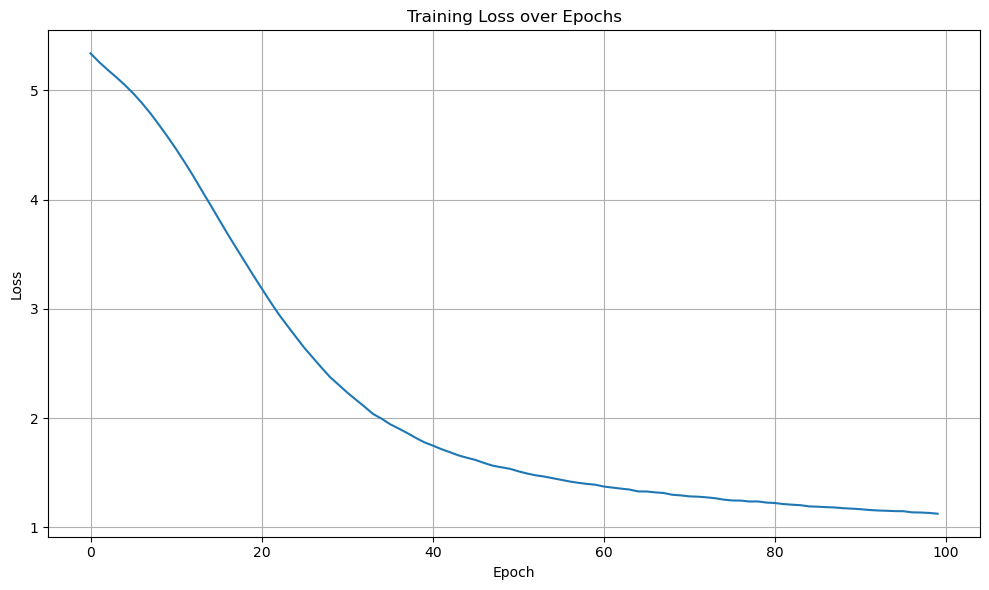

In [36]:
import matplotlib.pyplot as plt

# Loss values per epoch
loss_values = [
    5.3399, 5.2608, 5.1894, 5.1223, 5.0510, 4.9730, 4.8860, 4.7907, 4.6861, 4.5775,
    4.4638, 4.3434, 4.2180, 4.0855, 3.9549, 3.8219, 3.6896, 3.5621, 3.4372, 3.3109,
    3.1887, 3.0682, 2.9517, 2.8472, 2.7446, 2.6433, 2.5529, 2.4625, 2.3761, 2.3061,
    2.2355, 2.1704, 2.1076, 2.0400, 1.9967, 1.9457, 1.9060, 1.8651, 1.8209, 1.7801,
    1.7499, 1.7171, 1.6892, 1.6600, 1.6380, 1.6180, 1.5902, 1.5659, 1.5511, 1.5376,
    1.5143, 1.4943, 1.4778, 1.4665, 1.4514, 1.4361, 1.4210, 1.4090, 1.3990, 1.3914,
    1.3747, 1.3651, 1.3557, 1.3471, 1.3299, 1.3295, 1.3214, 1.3154, 1.2994, 1.2936,
    1.2848, 1.2819, 1.2758, 1.2679, 1.2549, 1.2471, 1.2462, 1.2377, 1.2385, 1.2280,
    1.2238, 1.2141, 1.2085, 1.2038, 1.1929, 1.1902, 1.1861, 1.1831, 1.1762, 1.1724,
    1.1673, 1.1603, 1.1557, 1.1531, 1.1499, 1.1489, 1.1385, 1.1371, 1.1332, 1.1261
]

epochs = list(range(len(loss_values)))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_values)
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.tight_layout()
plt.show()


In [16]:
out.shape

torch.Size([42000, 200])

In [22]:
with torch.no_grad():
    x = model.relu(model.gcn1(data.x, data.edge_index))
    newTrainEmbeddings = model.gcn2(x, data.edge_index)[data.train_mask]
    newValEmbeddings = model.gcn2(x, data.edge_index)[data.val_mask]
    newTestEmbeddings = model.gcn2(x, data.edge_index)[data.test_mask]


In [23]:
print(newTrainEmbeddings.shape)
print(newValEmbeddings.shape)
print(newTestEmbeddings.shape)


torch.Size([42000, 128])
torch.Size([9000, 128])
torch.Size([9000, 128])


In [25]:
import torch.nn.functional as F


In [29]:
# Normalize both sets of embeddings
train_norm = F.normalize(newTrainEmbeddings, dim=1)       # [42000, 128]
test_norm = F.normalize(newTestEmbeddings, dim=1)         # [9000, 128]

# Compute cosine similarity: matrix multiplication gives all pairwise cosines
cosine_sim_matrix = test_norm @ train_norm.T              # [9000, 42000]

# Get top-5 train article indices for each test embedding
topk_values, topk_indices = torch.topk(cosine_sim_matrix, k=5, dim=1)  # both [9000, 5]

In [34]:
topk_values.mean()

tensor(0.8668, device='cuda:1')

In [38]:
print(topk_values[0])
topk_indices[0]

tensor([0.8974, 0.7925, 0.7922, 0.7854, 0.7738], device='cuda:1')


tensor([30975, 20423, 16949, 17977, 29553], device='cuda:1')

In [46]:
test.iloc[0][["publication_ID", "title", "abstract"]]["title"]

'Elevated plasma endothelin 1 and pulmonary arterial pressure in children exposed to air pollution'

In [51]:
for idx in topk_indices[0]:
    print(df.iloc[idx.item()][["publication_ID", "title", "abstract"]]["publication_ID"])
    print(df.iloc[idx.item()][["publication_ID", "title", "abstract"]]["title"])

    print()

18368620
Systemic inflammation endothelial dysfunction and activation in clinically healthy children exposed to air pollutants

23788629
A synergistic vascular effect of airborne particulate matter and nickel in a mouse model

19297138
Urban air pollution influences on olfactory function and pathology in exposed children and young adults

19171930
Immunotoxicity and environment immunodysregulation and systemic inflammation in children

18939566
Spatial and temporal trends of polycyclic aromatic hydrocarbons and other traffic related airborne pollutants in New York City



In [43]:
idx = 30975
print(df.iloc[idx]["title"])
print(df.iloc[idx]["abstract"])
print(df.iloc[idx]["cluster"])

Systemic inflammation endothelial dysfunction and activation in clinically healthy children exposed to air pollutants
Mexico City children are chronically exposed to significant concentrations of air pollutants and exhibit chronic respiratory-tract inflammation. Epidemiological, controlled human exposures, laboratory-based animal models, and in vitro/in vivo studies have shown that inflammatory, endothelial dysfunction, and endothelial damage mediators are upregulated upon exposure to particulate matter (PM). Endothelial dysfunction is a critical event in cardiovascular disease. The focus of this work was to investigate whether exposure to ambient air pollution including PM(2.5) produces systemic inflammation and endothelial injury in healthy children. We measured markers of endothelial activation, and inflammatory mediators in 52 children age 8.6+/-0.1 yr, residents of Mexico City (n: 28) or of PolotitlÃ¡n (n: 24), a city with low levels of pollutants. Mexico City children had signifi

In [42]:
df.iloc[0]

publication_ID                                             17396995
Citations         17957262;21818356;24164861;21818356;24164861;2...
pubDate                                                  2007 May 1
language                                                        eng
title             Herpes simplex virus type 2 infection does not...
journal                          The Journal of infectious diseases
abstract          We sought to compare baseline and longitudinal...
keywords          Adult;California;epidemiology;Cohort Studies;H...
authors           Edward R Cachay; Simon D W Frost; Douglas D Ri...
venue                {'name': 'The Journal of infectious diseases'}
doi                                                  10.1086/513568
combined_text     Herpes simplex virus type 2 infection does not...
embedding         [0.025286998599767685, -0.01651591807603836, 0...
cluster                                                           6
Name: 0, dtype: object

In [46]:
idx = 0
print(df.iloc[idx]["title"])
print(df.iloc[idx]["abstract"])
print(df.iloc[idx]["cluster"])



Herpes simplex virus type 2 infection does not influence viral dynamics during early HIV 1 infection
We sought to compare baseline and longitudinal plasma HIV-1 loads between herpes simplex virus type 2 (HSV-2)-seropositive and -seronegative individuals who are enrolled in a primary HIV-1 infection cohort in San Diego, California.
6


In [50]:
idx = 4370

print(df.iloc[idx]["title"])
print(df.iloc[idx]["abstract"])
print(df.iloc[idx]["cluster"])


Herpes simplex virus type 2 acquisition during recent HIV infection does not influence plasma HIV levels
We assessed the effect of herpes simplex virus type 2 (HSV-2) acquisition on the plasma HIV RNA and CD4 cell levels among individuals with primary HIV infection using a retrospective cohort analysis. We studied 119 adult, antiretroviral-naive, recently HIV-infected men with a negative HSV-2-specific enzyme immunoassay (EIA) result at enrollment. HSV-2 acquisition was determined by seroconversion on HSV-2 EIA, confirmed by Western blot analysis. Ten men acquired HSV-2 infection a median of 1.3 years after HIV infection (HSV-2 incidence rate of 7.4 per 100 person-years of follow-up). The median time of follow-up after acquiring HSV-2 infection was 303 days. All men except 1 were asymptomatic during HSV-2 acquisition, and only 1 HSV-2 seroconverter, who was asymptomatic, had a transient increase in blood HIV load (0.5 log10 copies/mL over 11 days). The HSV-2 incidence rate was high in 

In [21]:
def info_nce_loss(proj, gcn, temperature=0.1):
    proj = torch.nn.functional.normalize(proj, dim=1)
    gcn = torch.nn.functional.normalize(gcn, dim=1)
    logits = torch.matmul(proj, gcn.T) / temperature
    labels = torch.arange(len(proj)).to(proj.device)
    return torch.nn.functional.cross_entropy(logits, labels)

def mse_alignment_loss(gcn_features, projected_features):
    return torch.nn.functional.mse_loss(projected_features, gcn_features)

def cosine_alignment_loss(gcn_features, projected_features):
    gcn_features = torch.nn.functional.normalize(gcn_features, dim=1)
    projected_features = torch.nn.functional.normalize(projected_features, dim=1)
    return 1 - (gcn_features * projected_features).sum(dim=1).mean()

In [22]:
projector = torch.nn.Sequential(
    torch.nn.Linear(768, 512),
    torch.nn.ReLU(),
    torch.nn.Linear(512, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 128),
).to(device)

In [ ]:
embeddingDataset = TensorDataset(torch.tensor(embeddings), newTrainEmbeddings)
embeddingsLoader = DataLoader(embeddingDataset, 128)

In [24]:
embeddings.shape

(42000, 768)

In [25]:
projectorOptim = torch.optim.Adam(projector.parameters(), lr=1e-3)


In [ ]:
# for epoch in tqdm(range(100)):
#     for sentenceFeat, gnnFeat in embeddingsLoader:
#         sentenceFeat, gnnFeat = sentenceFeat.to(device), gnnFeat.to(device)

#         projected_features = projector(sentenceFeat)

#         # Choose your loss
#         loss = cosine_alignment_loss(gnnFeat, projected_features)

#         projectorOptim.zero_grad()
#         loss.backward()
#         optimizer.step()

#     print(f"Epoch {epoch}: {loss.item()}")

import torch.nn.functional as F

for epoch in range(25):
    epoch_loss = 0.0
    epoch_mse = 0.0
    epoch_cos_sim = 0.0
    total_batches = 0

    projector.train()

    loop = tqdm(embeddingsLoader, desc=f"Epoch {epoch}", leave=False)
    for sentenceFeat, gnnFeat in loop:
        sentenceFeat, gnnFeat = sentenceFeat.to(device), gnnFeat.to(device)

        projected_features = projector(sentenceFeat)

        # Alignment loss (e.g., cosine loss or InfoNCE)
        loss = cosine_alignment_loss(gnnFeat, projected_features)

        # Metric 1: Cosine similarity
        cos_sim = F.cosine_similarity(
            F.normalize(projected_features, dim=1),
            F.normalize(gnnFeat, dim=1),
            dim=1
        ).mean().item()

        # Metric 2: MSE
        mse = F.mse_loss(projected_features, gnnFeat).item()

        projectorOptim.zero_grad()
        loss.backward()
        projectorOptim.step()

        # Track stats
        epoch_loss += loss.item()
        epoch_cos_sim += cos_sim
        epoch_mse += mse
        total_batches += 1

        loop.set_postfix(loss=loss.item(), cosine=cos_sim, mse=mse)

    # Averages for the epoch
    avg_loss = epoch_loss / total_batches
    avg_cos = epoch_cos_sim / total_batches
    avg_mse = epoch_mse / total_batches

    print(f"Epoch {epoch:03d} | Loss: {avg_loss:.4f} | Cosine Sim: {avg_cos:.4f} | MSE: {avg_mse:.4f}")

Epoch 0:   0%|          | 0/329 [00:00<?, ?it/s]

Epoch 000 | Loss: 0.0864 | Cosine Sim: 0.9136 | MSE: 4.1295


Epoch 001 | Loss: 0.0392 | Cosine Sim: 0.9608 | MSE: 3.7253


Epoch 002 | Loss: 0.0368 | Cosine Sim: 0.9632 | MSE: 3.4783


Epoch 003 | Loss: 0.0354 | Cosine Sim: 0.9646 | MSE: 3.2415


Epoch 004 | Loss: 0.0343 | Cosine Sim: 0.9657 | MSE: 3.0185


Epoch 005 | Loss: 0.0335 | Cosine Sim: 0.9665 | MSE: 2.8055


Epoch 006 | Loss: 0.0329 | Cosine Sim: 0.9671 | MSE: 2.5987


Epoch 007 | Loss: 0.0323 | Cosine Sim: 0.9677 | MSE: 2.3991


Epoch 008 | Loss: 0.0317 | Cosine Sim: 0.9683 | MSE: 2.2088


Epoch 009 | Loss: 0.0312 | Cosine Sim: 0.9688 | MSE: 2.0289


Epoch 010 | Loss: 0.0307 | Cosine Sim: 0.9693 | MSE: 1.8558


Epoch 011 | Loss: 0.0303 | Cosine Sim: 0.9697 | MSE: 1.6911


Epoch 012 | Loss: 0.0299 | Cosine Sim: 0.9701 | MSE: 1.5356


Epoch 013 | Loss: 0.0295 | Cosine Sim: 0.9705 | MSE: 1.3894


Epoch 014 | Loss: 0.0291 | Cosine Sim: 0.9709 | MSE: 1.2518


Epoch 015 | Loss: 0.0288 | Cosine Sim: 0.9712 | MSE: 1.1242


Epoch 016 | Loss: 0.0284 | Cosine Sim: 0.9716 | MSE: 1.0080


Epoch 017 | Loss: 0.0280 | Cosine Sim: 0.9720 | MSE: 0.9026


Epoch 018 | Loss: 0.0276 | Cosine Sim: 0.9724 | MSE: 0.8089


Epoch 019 | Loss: 0.0273 | Cosine Sim: 0.9727 | MSE: 0.7269


Epoch 020 | Loss: 0.0269 | Cosine Sim: 0.9731 | MSE: 0.6547


Epoch 021 | Loss: 0.0266 | Cosine Sim: 0.9734 | MSE: 0.5918


Epoch 022 | Loss: 0.0263 | Cosine Sim: 0.9737 | MSE: 0.5374


Epoch 023 | Loss: 0.0260 | Cosine Sim: 0.9740 | MSE: 0.4919


Epoch 024 | Loss: 0.0257 | Cosine Sim: 0.9743 | MSE: 0.4538


KeyboardInterrupt: 

In [27]:
query = sentTransformer.encode("Does HSV-2 infection affect HIV-1 viral load during early infection?", convert_to_tensor=True).unsqueeze(0)

In [46]:
projector(query)

tensor([[ 0.9475,  0.1267, -0.7355,  2.3193, -1.0245,  5.4224, -0.2830,  5.3337,
          1.1157, -1.3054,  0.9092,  3.5090,  0.9092, -1.9904,  5.9561,  1.8709,
         -0.8519,  4.1124, -5.8601, -3.2842,  0.8364, -1.7003, -2.5755,  2.5388,
          0.1860, -4.8581, -0.0871, -0.0883, -4.0005,  0.4310,  3.0253,  0.5420,
          1.1632,  0.6783, -1.9242, -0.5274, -2.2086, -2.8591, -1.2566,  3.7541,
          1.6410, -5.4824, -4.4069, -2.0614, -1.3832, -0.8065, -2.8015, -4.5868,
          0.4555,  2.3108,  0.7342, -0.4800,  4.1041,  0.5223,  4.1886, -1.6070,
         -1.0340, -0.6285, -3.6189, -2.9228, -2.0556,  0.5181,  3.5922, -3.6828,
         -2.5354, -0.7375, -2.1428,  1.0271,  2.0640, -0.4872,  0.1799,  2.5157,
         -0.1506, -3.8132, -3.9102,  3.4707, -1.8599,  0.8882,  0.1442, -1.5927,
         -1.5980,  0.3055,  1.0181, -4.4591, -0.9713, -0.6892, -0.2785, -1.7720,
         -0.9992,  1.6119, -1.3113,  2.3926, -1.3130,  1.7119, -0.3259,  1.3891,
          0.5427, -1.0244, -

In [ ]:
cosine_sim = F.cosine_similarity(projector(query), newTrainEmbeddings, dim=1)  # shape: [N]

topk = torch.topk(cosine_sim, k=10)  # top 5 most similar articles
topk_indices = topk.indices
topk_scores = topk.values


In [38]:
print(topk_scores)
topk_indices

tensor([0.9207, 0.8988, 0.8988, 0.8958, 0.8947, 0.8916, 0.8899, 0.8866, 0.8835,
        0.8832], device='cuda:1', grad_fn=<TopkBackward0>)


tensor([    0, 20621,  4707,  4370, 19191, 21945, 32237, 16548,  8605,  3334],
       device='cuda:1')

In [58]:
print(topk_scores)
topk_indices

tensor([0.9356, 0.9348, 0.9341, 0.9319, 0.9285], device='cuda:1',
       grad_fn=<TopkBackward0>)


tensor([32237, 16548,     0,  4370,  3334], device='cuda:1')

In [34]:
idx = 4370
print(df.iloc[idx]["title"])
print(df.iloc[idx]["abstract"])
print(df.iloc[idx]["cluster"])



Herpes simplex virus type 2 acquisition during recent HIV infection does not influence plasma HIV levels
We assessed the effect of herpes simplex virus type 2 (HSV-2) acquisition on the plasma HIV RNA and CD4 cell levels among individuals with primary HIV infection using a retrospective cohort analysis. We studied 119 adult, antiretroviral-naive, recently HIV-infected men with a negative HSV-2-specific enzyme immunoassay (EIA) result at enrollment. HSV-2 acquisition was determined by seroconversion on HSV-2 EIA, confirmed by Western blot analysis. Ten men acquired HSV-2 infection a median of 1.3 years after HIV infection (HSV-2 incidence rate of 7.4 per 100 person-years of follow-up). The median time of follow-up after acquiring HSV-2 infection was 303 days. All men except 1 were asymptomatic during HSV-2 acquisition, and only 1 HSV-2 seroconverter, who was asymptomatic, had a transient increase in blood HIV load (0.5 log10 copies/mL over 11 days). The HSV-2 incidence rate was high in 

In [70]:
pubIdToId[9738515]

1478

In [ ]:
for val in topk_indices:
    pubID = df.iloc[val.cpu().item()]["publication_ID"]
    title = df.iloc[val.cpu().item()]["title"]
    
    print(f"{pubID}: {title}")


17957262: HIV 1 HSV 2 co infected adults in early HIV 1 infection have elevated CD4 T cell counts
16973556: Selection on the human immunodeficiency virus type 1 proteome following primary infection
17396995: Herpes simplex virus type 2 infection does not influence viral dynamics during early HIV 1 infection
18197122: Herpes simplex virus type 2 acquisition during recent HIV infection does not influence plasma HIV levels
18936487: HIV rebounds from latently infected cells rather than from continuing low level replication


In [ ]:
1478

In [74]:
df[df["publication_ID"] == 9738515]

,publication_ID,Citations,pubDate,language,title,journal,abstract,keywords,authors,venue,doi,combined_text,embedding,cluster
888,9738515,22408488;21943363;20878774;30075569;31996227;3...,1998 Sep,eng,Early changes in biochemical markers of bone t...,Journal of bone and mineral research : the off...,Although the antiresorptive agent alendronate ...,Aged;Alendronate;administration & dosage;thera...,S L Greenspan; R A Parker; L Ferguson; H N Ros...,{'name': 'Journal of bone and mineral research...,10.1359/jbmr.1998.13.9.1431,Early changes in biochemical markers of bone t...,"[0.0006918551516719162, -0.038948796689510345,...",67


In [75]:
df.iloc[888]["title"]

'Early changes in biochemical markers of bone turnover predict the long term response to alendronate therapy in representative elderly women a randomized clinical trial'

In [39]:
embeddings.shape

(42000, 768)

In [40]:
testData = pd.read_csv("./publications_test.csv")

In [44]:
testData.head()

,publication_ID,Citations,pubDate,language,title,journal,abstract,keywords,authors,venue,doi
0,17687455,18288294;21106102;22632576;23509683;23986703;2...,2007 Aug,eng,Elevated plasma endothelin 1 and pulmonary art...,Environmental health perspectives,Background Controlled exposures of animals and...,Adolescent;Air Pollutants;analysis;toxicity;Ai...,Lilian Calderón-Garcidueñas; Renaud Vincent; A...,"{'name': 'Environmental health perspectives', ...",10.1289/ehp.9641
1,18000457,30090625,2007 Nov,eng,A Latent Class Analysis LCA of problem gamblin...,The Journal of nervous and mental disease,Problem gambling rates are relatively low (2%-...,"Adolescent;Adult;Aged;Aged, 80 and over;Awaren...",Renee M. Cunningham-Williams; Song Iee Hong,{'name': 'The Journal of nervous and mental di...,10.1097/NMD.0b013e31815947e1
2,21359119,31763180;32373066,2010 Sep 29,ENG,Aripiprazole for irritability associated with ...,Pediatric health,Aripiprazole was recently US FDA-approved to t...,0,Kelly Blankenship; Craig A Erickson; Kimberly ...,"{'name': 'Pediatric health', 'id': '5451a5cae0...",10.2217/phe.10.45
3,18991128,25267381;29357099;31650460;34135829;34177747;3...,2008 Oct,ENG,Refining the classification of children with s...,Journal of clinical child and adolescent psych...,The goal of this study was to develop an empir...,Anxiety Disorders;classification;diagnosis;psy...,Sharon L. Cohan; Denise A. Chavira; Elisa Ship...,{'name': 'Journal of clinical child and adoles...,10.1080/15374410802359759
4,20668223,24409178;24409177;24065969;25875653;25333930;3...,2010 Sep 1,eng,GILT accelerates autoimmunity to the melanoma ...,"Journal of immunology (Baltimore, Md. : 1950)","Melanocyte differentiation Ags, including tyro...",Adoptive Transfer;Amino Acid Sequence;Animals;...,Matthew P Rausch; Kari R Irvine; Paul A Antony...,"{'name': 'Journal of immunology (Baltimore, Md...",10.4049/jimmunol.1000945


In [ ]:

avgCosSims = []

for index, row in testData.iterrows():
    # pubIdToCommunity[int(row["node_id"])] = int(row["community_id"])
    sentence = row["title"] + ". " + str(row["abstract"])
    query = sentTransformer.encode(sentence, convert_to_tensor=True).unsqueeze(0)

    cosine_sim = F.cosine_similarity(projector(query), newTrainEmbeddings, dim=1)  # shape: [N]

    topk = torch.topk(cosine_sim, k=10)  # top 5 most similar articles
    # topk_indices = topk.indices
    topk_scores = topk.values

    avgCosSims.append(topk_scores.mean().item())



In [50]:
np.mean(avgCosSims)

0.8426524486409294